In [1]:
import datasets
import pandas as pd
human_data = datasets.load_dataset('boda/review_evaluation_human_annotation', name = 'combined_main_aspects', split = 'full').to_pandas()


# # Load the test and train splits
# test_data = datasets.load_dataset("boda/review_evaluation_automatic_labels", name='all', split='test').to_pandas()
# train_data = datasets.load_dataset("boda/review_evaluation_automatic_labels", name='all', split='train').to_pandas()
# # Merge the test and train splits into one dataframe
# synthetic_data = pd.concat([test_data, train_data], ignore_index=True)


In [2]:
venue_aspect_means = human_data.groupby('venue')
# venue_aspect_means = synthetic_data.groupby('venue')


In [3]:
# Initialize an empty dictionary to store the results
aspects = [ 'actionability', 'grounding_specificity','verifiability', 'helpfulness']
aspect_dict = {
    'actionability_mean': None,
    'grounding_specificity_mean': None,
    'verifiability_mean': None,
    'helpfulness_mean': None
}

# Iterate over the venues and calculate the mean for each aspect
for venue, group in venue_aspect_means:
    scores = {    # Initialize cumulative scores for each aspect
        'actionability': 0,
        'grounding_specificity': 0,
        'verifiability': 0,
        'helpfulness': 0
    }
    verifiability_cnt = 0
    # Iterate over the rows in the group
    for aspect in aspects:

        filtired_group = group[group[f'{aspect}_label_type'] != 'hard']
        for _, row in filtired_group.iterrows():


            score = 0
            cnt = 0
            row_average_score = 0
            if aspect not in row:
                score = row[f'chatgpt_{aspect}_score']
                if score != 'X':
                    cnt += 1
                    score = int(score)
                    row_average_score = score
                    if aspect == 'verifiability':
                        # Check if the score is not 'X' and increment the count
                        verifiability_cnt += 1
            else:
                for s in row[aspect]['labels']:
                    if s != 'X':
                        cnt += 1
                        score += int(s)
                if cnt != 0:
                    row_average_score = score / cnt
                    if aspect == 'verifiability':
                        # Check if the score is not 'X' and increment the count
                        verifiability_cnt += 1
                else:
                    row_average_score = 0
                # Add the score to the cumulative score for the aspect
            scores[aspect] += row_average_score
    # Calculate the mean for each aspect
    for aspect in aspects:
        # Calculate the mean for the aspect
        length = len(filtired_group) if aspect != 'verifiability' else verifiability_cnt
        aspect_mean = scores[aspect] / length
        # Store the mean in the dictionary

        if aspect_dict[f'{aspect}_mean'] is None:
            aspect_dict[f'{aspect}_mean'] = {}
        aspect_dict[f'{aspect}_mean'][venue] = aspect_mean
        

print(aspect_dict)

{'actionability_mean': {'ACL_2017': 4.333333333333333, 'ARR_2022': 4.600000000000002, 'EMNLP_2023': 3.417624521072797, 'ICLR_2021': 4.598870056497175, 'ICLR_2022': 3.6799999999999993, 'ICLR_2023': 4.16190476190476, 'ICLR_2024': 4.003921568627451, 'ICLR_2025': 4.0, 'NIPS_2016': 4.5930735930735915, 'NIPS_2017': 4.121621621621622, 'NIPS_2018': 4.192307692307693, 'NIPS_2019': 4.409090909090907, 'NIPS_2020': 4.547619047619049, 'NIPS_2021': 4.887254901960787, 'NIPS_2022': 3.739130434782607}, 'grounding_specificity_mean': {'ACL_2017': 4.3933333333333335, 'ARR_2022': 4.795555555555555, 'EMNLP_2023': 4.5823754789272035, 'ICLR_2021': 5.118644067796611, 'ICLR_2022': 4.062222222222222, 'ICLR_2023': 4.966666666666668, 'ICLR_2024': 5.309803921568628, 'ICLR_2025': 4.553191489361701, 'NIPS_2016': 4.714285714285715, 'NIPS_2017': 4.797297297297297, 'NIPS_2018': 4.6239316239316235, 'NIPS_2019': 5.020202020202021, 'NIPS_2020': 4.96031746031746, 'NIPS_2021': 4.936274509803921, 'NIPS_2022': 4.29951690821256

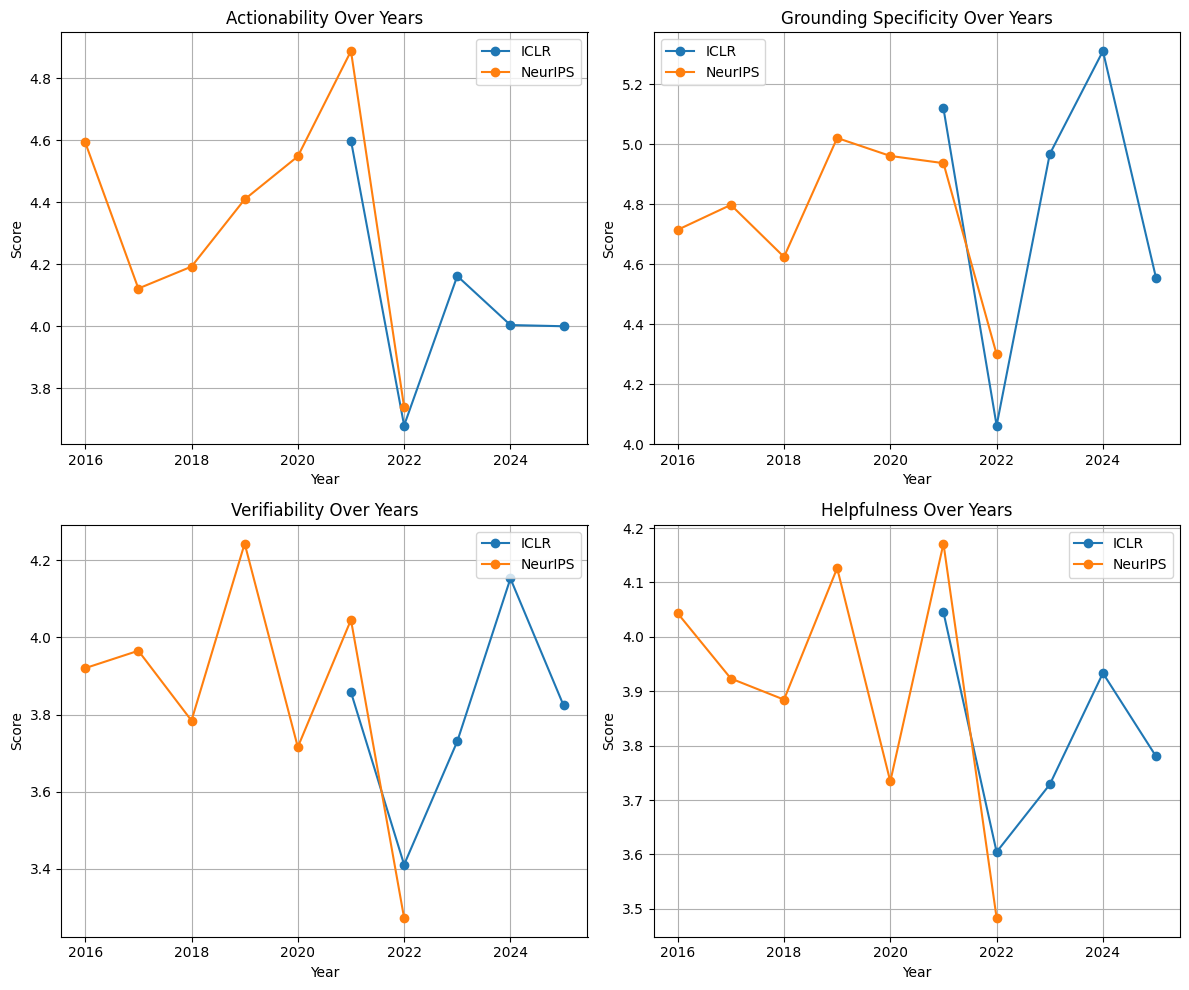

In [5]:
import matplotlib.pyplot as plt

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Filter data to include only ICLR and NIPS (renamed to NeurIPS)
filtered_data = {}
for aspect_key, venues_scores in aspect_dict.items():
    aspect_name = aspect_key.replace('_mean', '')
    filtered_data[aspect_name] = {}
    for venue_year, score in venues_scores.items():
        venue, year = venue_year.rsplit('_', 1)
        year = int(year)
        if venue in ['ICLR', 'NIPS']:
            if venue == 'NIPS':
                venue = 'NeurIPS'  # Rename NIPS to NeurIPS
            if venue not in filtered_data[aspect_name]:
                filtered_data[aspect_name][venue] = {}
            filtered_data[aspect_name][venue][year] = score

# Plotting each aspect
for idx, (aspect, venues_data) in enumerate(filtered_data.items()):
    ax = axes[idx]
    for venue, year_score in venues_data.items():
        years = sorted(year_score.keys())
        scores = [year_score[year] for year in years]
        ax.plot(years, scores, marker='o', label=venue)
    ax.set_title(f"{aspect.replace('_', ' ').title()} Over Years")
    ax.set_xlabel("Year")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("outputs/qulity_over_years.pdf", format="pdf")
plt.show()
